In [2]:
import os
import sys

sys.path.append("../scripts")

import pandas as pd
from metrics import per_source_metrics
from openai import AzureOpenAI
from plot_utils import plot_confusion_matrix
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm

In [ ]:
model_deployment_name = "gpt-4.1-mini-fsa-01"

In [ ]:
client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_ENDPOINT"),
    api_key=os.getenv("AZURE_API_KEY"),
    api_version="2024-12-01-preview",
)

In [3]:
val_df = pd.read_csv("../data/processed/val.csv")

In [4]:
prompts = [
    {
        "role": "system",
        "content": "You are a financial sentiment classifier. Respond with one word: neutral, positive, or negative.",
    }
]

sentences = val_df["sentence"].tolist()
true_labels = val_df["label"].tolist()

In [ ]:
preds = []

for i, sentence in tqdm(enumerate(sentences)):
    response = client.chat.completions.create(
        messages=prompts
        + [
            {
                "role": "user",
                "content": f"Classify the sentiment of this sentence: {sentence}",
            }
        ],
        max_completion_tokens=10000,
        model=model_deployment_name,
    )
    result = response.choices[0].message.content.strip().lower()
    preds.append(result)

    # print(f"{i}\ngpt-4.1-mini-ft: {result}\nvalidation: {true_labels[i]}\n")

1781it [36:07,  1.22s/it]


In [ ]:
# preds = []

# for sentence in tqdm(sentences):
#     response = client.chat.completions.create(
#         messages=prompts
#         + [
#             {
#                 "role": "user",
#                 "content": f"Classify the sentiment of this sentence: {sentence}",
#             }
#         ],
#         temperature=0.0,
#         max_tokens=5,
#         model=model_deployment_name,
#     )
#     result = response.choices[0].message.content.strip().lower()
#     preds.append(result)

#     # print(f"{i}\ngpt-4.1-mini-ft: {result}\nvalidation: {true_labels[i]}\n")

In [ ]:
with open("../models/gpt-4.1/gpt-4.1-mini-ft-preds.txt", "w") as f:
    for label in preds:
        f.write(label + "\n")

In [ ]:
report = classification_report(true_labels, preds)
print(report)

              precision    recall  f1-score   support

    negative       0.88      0.81      0.85       274
     neutral       0.89      0.93      0.91      1064
    positive       0.86      0.81      0.84       443

    accuracy                           0.88      1781
   macro avg       0.88      0.85      0.86      1781
weighted avg       0.88      0.88      0.88      1781



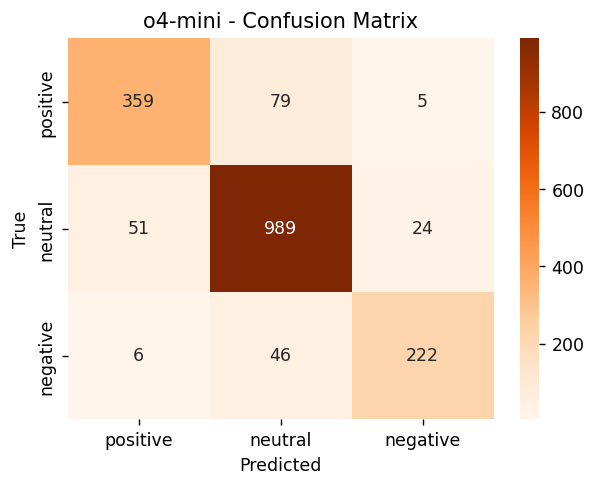

In [ ]:
plot_confusion_matrix(
    true_labels,
    preds,
    labels=["positive", "neutral", "negative"],
    title="o4-mini - Confusion Matrix",
    cmap="Oranges",
)

In [ ]:
per_source_results = per_source_metrics(true_labels, preds, val_df["source"])
print("GPT-4.1-mini-fine-tuned Per-Source Performance:\n")
for source, acc, f1 in per_source_results:
    print(f"{source}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}")

GPT-4.1-mini-fine-tuned Per-Source Performance:

FPB: Accuracy=0.862, Macro-F1=0.858
Twitter: Accuracy=0.902, Macro-F1=0.873
FiQA: Accuracy=0.741, Macro-F1=0.677


In [30]:
f1_score(true_labels, preds, average="macro")

0.8632475224199218

In [12]:
pd.DataFrame(
    classification_report(true_labels, preds, output_dict=True)
).transpose().to_csv("../models/gpt-4.1/gpt-4.1-mini-preds.csv")